# Climate Claim Classification: Zero-Shot vs. Few-Shot Learning

This notebook demonstrates and compares two advanced Natural Language Processing (NLP) paradigms – **Zero-Shot Learning (ZSL)** and **Few-Shot Learning (FSL)** – for the task of classifying climate-related claims. 

The goal is to distinguish, with claim-evidence pairs, whether the claim is related (1) or unrelated (0) to the evidence.

Data source: https://huggingface.co/datasets/mwong/climate-claim-related


## Table of Contents
1.  [Data Loading and Preparation](#1.-Data-Loading-and-Preparation)
2.  [Zero-Shot Learning (ZSL) with NLI](#2.-Zero-Shot-Learning-(ZSL)-with-NLI)
3.  [Few-Shot Learning (FSL) with SetFit](#3.-Few-Shot-Learning-(FSL)-with-SetFit)
4.  [Visualization: Confusion Matrices](#4.-Visualization:-Confusion-Matrices)

In [ ]:
import pandas as pd
from datasets import load_dataset, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from setfit import SetFitModel, SetFitTrainer, sample_dataset
from pprint import pprint
import setfit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
import os
from transformers import (AutoTokenizer, AutoModel,
                          AutoModelForSequenceClassification,
                          TrainingArguments, Trainer,
                          EarlyStoppingCallback)
import numpy as np

## 1. Data Loading and Preparation

### Data

In [2]:
# --- 1. Load and Prepare Dataset ---
print("Loading 'mwong/climate-claim-related' dataset...")
dataset = load_dataset("mwong/climate-claim-related")
train_df = dataset['train']
val_df = dataset['valid']
test_df = dataset['test']

# Define label mapping for the identified classes
labels_map = {0: 'not related', 1: 'related'}
candidate_labels = list(labels_map.values())

# Convert the dataset to a pandas DataFrame for easier manipulation
train_df = train_df.to_pandas()
train_df['label_name'] = train_df['labels'].map(labels_map)

val_df = val_df.to_pandas()
val_df['label_name'] = val_df['labels'].map(labels_map)

test_df = test_df.to_pandas()
test_df['label_name'] = test_df['labels'].map(labels_map)

print("Actual labels in the training set:", train_df['label_name'].unique())

# --- 2. Basic EDA ---

# Check the length of each of the splits
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Check how balanced is the target across all splits
print("\nDistribution of labels in the training set:")
print(train_df['label_name'].value_counts(normalize=True))

print("\nDistribution of labels in the validation set:")
print(val_df['label_name'].value_counts(normalize=True))

print("\nDistribution of labels in the test set:")
print(test_df['label_name'].value_counts(normalize=True))

# --- 3. Extract validation and test data ---

# Extract claims and true labels for the validation set
val_claims = val_df['claim'].tolist()
val_evidence = val_df['evidence'].tolist()
y_val_true = val_df['label_name'].tolist()

# Extract claims and true labels for the test set
test_claims = test_df['claim'].tolist()
test_evidence = test_df['evidence'].tolist()
y_test_true = test_df['label_name'].tolist()

# Concatenate the claims and evidence for validation and test sets
val_concat_text = [f"Claim: {claim}\nEvidence: {evidence}" for claim, evidence in zip(val_claims, val_evidence)]
test_concat_text= [f"Claim: {claim}\nEvidence: {evidence}" for claim, evidence in zip(test_claims, test_evidence)]

# --- 4. Print 3 example claims, the evidence and the labels ---
print("\nExample claims and evidence from the test set:")
for i in range(3):
    print(f"Claim and evidence {i+1}:\n{test_concat_text[i]}")
    print(f"Label: {y_test_true[i]}\n")

Loading 'mwong/climate-claim-related' dataset...
Actual labels in the training set: ['related' 'not related']
Training set size: 12280
Validation set size: 2456
Test set size: 614

Distribution of labels in the training set:
label_name
related        0.5
not related    0.5
Name: proportion, dtype: float64

Distribution of labels in the validation set:
label_name
related        0.5
not related    0.5
Name: proportion, dtype: float64

Distribution of labels in the test set:
label_name
not related    0.5
related        0.5
Name: proportion, dtype: float64

Example claims and evidence from the test set:
Claim and evidence 1:
Claim: A cold day in Chicago in winter has nothing to do with the trend of global warming.
Evidence: "A novel probabilistic forecast system predicting anomalously warm 2018–2022 reinforcing the long-term global warming trend".
Label: not related

Claim and evidence 2:
Claim: “…climate change will also reduce the number of cold days and cold spells.
Evidence: An alterna

i.e., the distribution of labels is exactly the same across all splits. This removes the need for doing stratified sampling, since the splits are already stratified.

### Utilities

In [ ]:
def evaluate_classification(y_true, y_pred, base_filename, labels=None, probas=None, results_dir="results"):
    """
    Evaluates classification performance and saves visualization results
    
    Parameters:
    -----------
    y_true : list or array
        Ground truth labels
    y_pred : list or array
        Predicted labels
    base_filename : str
        Base name for saved files (e.g. "zero_shot", "few_shot")
    labels : list, optional
        List of class labels
    probas : array-like, optional
        Predicted probabilities for ROC and PR curves
    results_dir : str, optional
        Directory to save results
        
    Returns:
    --------
    dict: Dictionary containing metrics and report
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                                roc_curve, auc, precision_recall_curve, average_precision_score)
    
    # Create results directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    
    # Ensure labels are provided
    if labels is None:
        labels = sorted(list(set(y_true)))
    
    # Check if model predicts only one class
    unique_predicted = set(y_pred)
    if len(unique_predicted) == 1:
        print(f"Warning: Model only predicts one class: {unique_predicted}")

    # 1. Classification report with accuracy
    report = classification_report(y_true, y_pred, labels=labels, zero_division=0)  # Metric is set to zero for undefined cases
    print(report)
    
    # 2. Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {base_filename}')
    plt.tight_layout()
    cm_path = f"{results_dir}/{base_filename}_confusion_matrix.png"
    plt.savefig(cm_path, dpi=400)
    plt.show()
    plt.close()
    
    results = {
        "report": report,
        "saved_files": [cm_path]
    }
    
    # Process probabilities for ROC and PR curves if provided
    if probas is not None:
        # Convert labels to binary format for the curves
        unique_labels = sorted(list(set(y_true)))
        label_to_idx = {label: i for i, label in enumerate(unique_labels)}
        y_binary = np.array([label_to_idx[y] for y in y_true])
        y_score = probas
        
        # 3. ROC curve
        fpr, tpr, _ = roc_curve(y_binary, y_score)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {base_filename}')
        plt.legend(loc="lower right")
        plt.tight_layout()
        roc_path = f"{results_dir}/{base_filename}_roc_curve.png"
        plt.savefig(roc_path, dpi=400)
        plt.show()
        plt.close()
        results["saved_files"].append(roc_path)
        
        # 4. Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_binary, y_score)
        avg_precision = average_precision_score(y_binary, y_score)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2, 
                label=f'Precision-Recall (AP = {avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title(f'Precision-Recall Curve - {base_filename}')
        plt.legend(loc="lower left")
        plt.tight_layout()
        pr_path = f"{results_dir}/{base_filename}_pr_curve.png"
        plt.savefig(pr_path, dpi=400)
        plt.show()
        plt.close()
        results["saved_files"].append(pr_path)
        
        # Add AUC metrics to results
        results["roc_auc"] = roc_auc
        results["avg_precision"] = avg_precision
    
    return results

## 2. Zero-Shot Learning (ZSL) with NLI

### With default NLI template

Running Zero-Shot Learning classification...


Device set to use cuda:0


Zero-Shot Learning predictions completed.

("Prediction 1: {'sequence': 'Claim: A cold day in Chicago in winter has "
 'nothing to do with the trend of global warming.\\nEvidence: "A novel '
 'probabilistic forecast system predicting anomalously warm 2018–2022 '
 'reinforcing the long-term global warming trend".\', \'labels\': [\'not '
 "related', 'related'], 'scores': [0.7414495944976807, 0.2585504353046417]}")
("Prediction 2: {'sequence': 'Claim: “…climate change will also reduce the "
 'number of cold days and cold spells.\\nEvidence: An alternative criticism is '
 'that the Church opposed particular scientific discoveries that it felt '
 'challenged its authority and power – particularly through the Reformation '
 "and on through the Enlightenment.', 'labels': ['related', 'not related'], "
 "'scores': [0.9925256371498108, 0.0074743423610925674]}")
("Prediction 3: {'sequence': 'Claim: Donald Trump thinks that climate change "
 'is a hoax, invented by the Chinese.\\nEvidence: With Gi

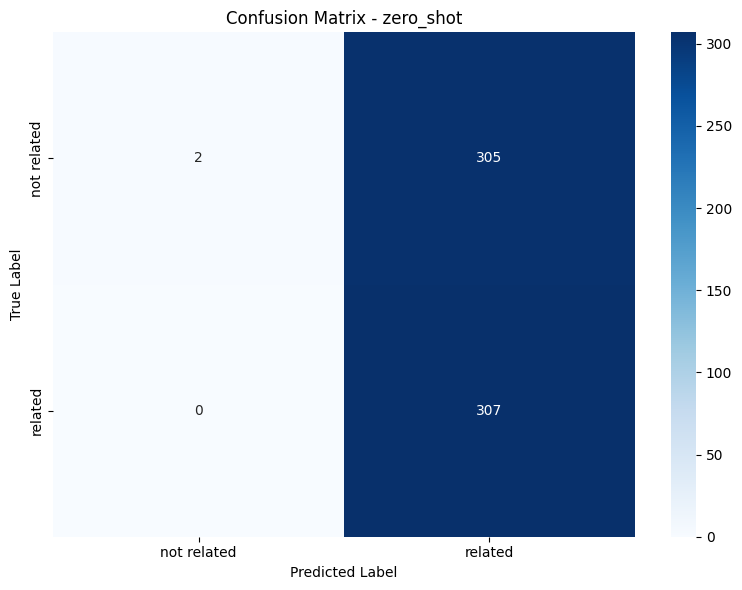

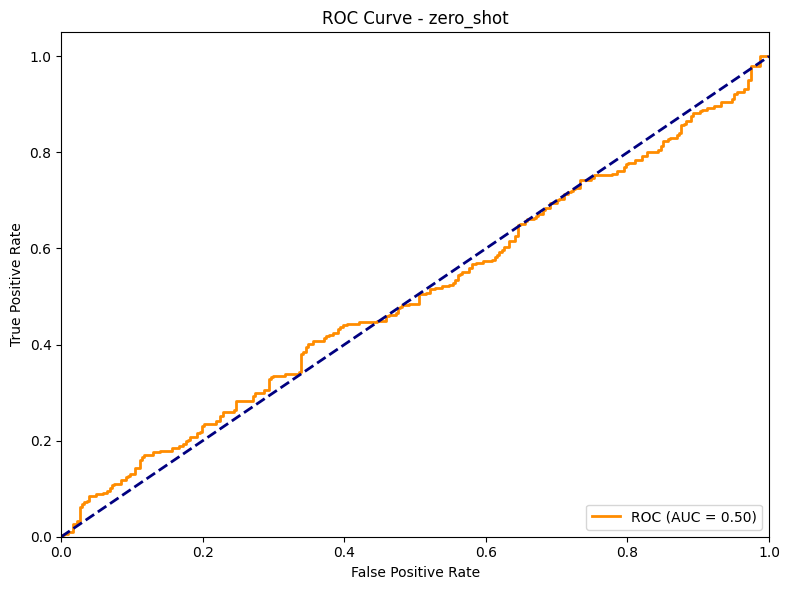

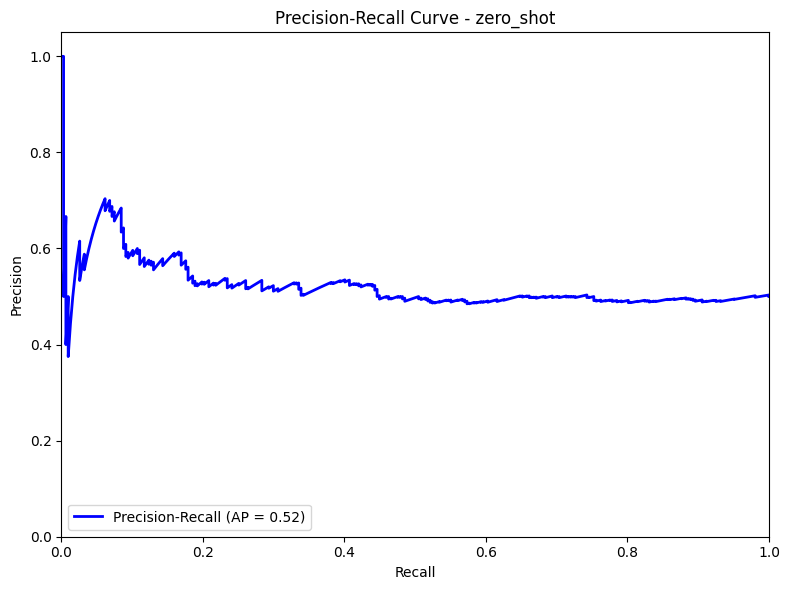

In [ ]:
print("Running Zero-Shot Learning classification...")
zsl_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

zsl_preds_raw = zsl_classifier(  # Automatically classify the claims based on the evidence, using a hypothesis template
    test_concat_text,  # Pass the claim-evidence pairs as a single text input
    candidate_labels=candidate_labels,  # Candidate labels for classification in natural language
    multi_label=False,  # False since a claim-evidence pair can only belong to one class
)
print("Zero-Shot Learning predictions completed.\n")

# Extract predictions and probabilities
y_pred_zsl = [pred['labels'][0] for pred in zsl_preds_raw]

# Extract probabilities for the positive class ('related')
zsl_probas = []
for pred in zsl_preds_raw:
    # Find the index of 'related' in the labels list
    related_idx = pred['labels'].index('related')
    # Get the corresponding score
    related_prob = pred['scores'][related_idx]
    zsl_probas.append(related_prob)

# Print the first 3 predictions and their probabilities
for i in range(3):
    pprint(f"Prediction {i+1}: {zsl_preds_raw[i]}")

# Evaluate the zero-shot learning results
zsl_results = evaluate_classification(
    y_true=y_test_true,
    y_pred=y_pred_zsl,
    base_filename="zero_shot_nli",
    labels=candidate_labels,
    probas=zsl_probas,
    results_dir="results"
)

### With custom NLI template

Running Zero-Shot Learning classification...


Device set to use cuda:0


Zero-Shot Learning predictions completed.

("Prediction 1: {'sequence': 'Claim: A cold day in Chicago in winter has "
 'nothing to do with the trend of global warming.\\nEvidence: "A novel '
 'probabilistic forecast system predicting anomalously warm 2018–2022 '
 'reinforcing the long-term global warming trend".\', \'labels\': '
 "['related', 'not related'], 'scores': [0.7698357105255127, "
 '0.2301642894744873]}')
("Prediction 2: {'sequence': 'Claim: “…climate change will also reduce the "
 'number of cold days and cold spells.\\nEvidence: An alternative criticism is '
 'that the Church opposed particular scientific discoveries that it felt '
 'challenged its authority and power – particularly through the Reformation '
 "and on through the Enlightenment.', 'labels': ['related', 'not related'], "
 "'scores': [0.9883836507797241, 0.011616337113082409]}")
("Prediction 3: {'sequence': 'Claim: Donald Trump thinks that climate change "
 'is a hoax, invented by the Chinese.\\nEvidence: With 

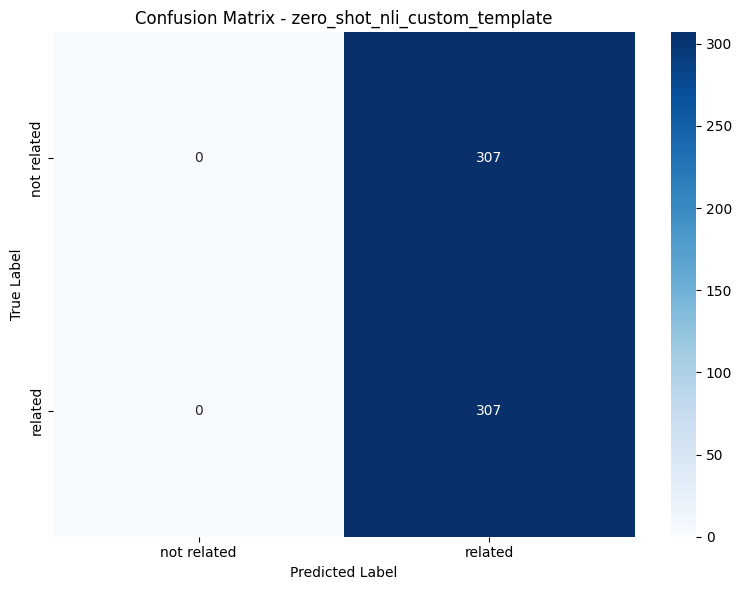

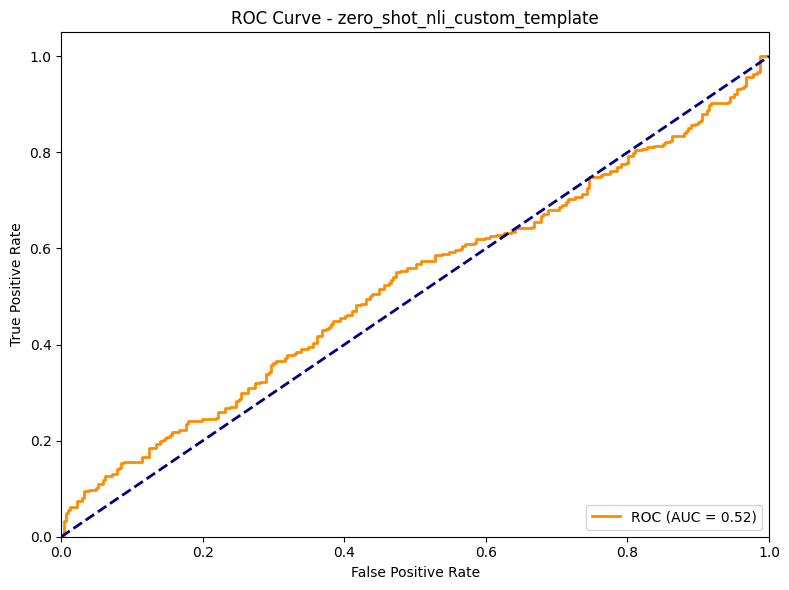

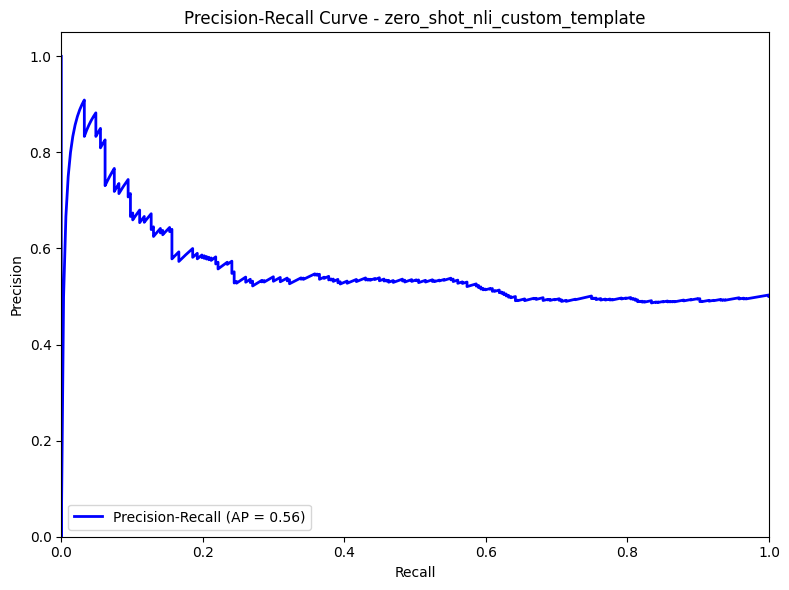

In [39]:
print("Running Zero-Shot Learning classification...")
zsl_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

zsl_preds_raw = zsl_classifier(
    test_concat_text,  # Pass the claim-evidence pairs as a single text input
    candidate_labels=candidate_labels,  # Candidate labels for classification in natural language
    multi_label=False,  # False since a claim-evidence pair can only belong to one class
    hypothesis_template="This claim is {} to the evidence."  # Automatically creates hypotheses from candidate labels
)
print("Zero-Shot Learning predictions completed.\n")

# Extract predictions and probabilities
y_pred_zsl = [pred['labels'][0] for pred in zsl_preds_raw]

# Extract probabilities for the positive class ('related')
zsl_probas = []
for pred in zsl_preds_raw:
    # Find the index of 'related' in the labels list
    related_idx = pred['labels'].index('related')
    # Get the corresponding score
    related_prob = pred['scores'][related_idx]
    zsl_probas.append(related_prob)

# Print the first 3 predictions and their probabilities
for i in range(3):
    pprint(f"Prediction {i+1}: {zsl_preds_raw[i]}")

# Evaluate the zero-shot learning results
zsl_results = evaluate_classification(
    y_true=y_test_true,
    y_pred=y_pred_zsl,
    base_filename="zero_shot_nli_custom_template",
    labels=candidate_labels,
    probas=zsl_probas,
    results_dir="results"
)

### What if we just provided the claim?

The idea is that, maybe, just by the wording of the claim we are able to detect whether it relies on actual evidence or not. Let's check it out.

Running Zero-Shot Learning classification...


Device set to use cuda:0


Zero-Shot Learning predictions completed.

("Prediction 1: {'sequence': 'A cold day in Chicago in winter has nothing to "
 "do with the trend of global warming.', 'labels': ['not related', 'related'], "
 "'scores': [0.9882627129554749, 0.011737341992557049]}")
("Prediction 2: {'sequence': '“…climate change will also reduce the number of "
 "cold days and cold spells.', 'labels': ['related', 'not related'], 'scores': "
 '[0.9956225156784058, 0.004377482924610376]}')
("Prediction 3: {'sequence': 'Donald Trump thinks that climate change is a "
 "hoax, invented by the Chinese.', 'labels': ['related', 'not related'], "
 "'scores': [0.9868194460868835, 0.013180602341890335]}")
Accuracy: 0.5065

              precision    recall  f1-score   support

 not related       0.70      0.02      0.04       307
     related       0.50      0.99      0.67       307

    accuracy                           0.51       614
   macro avg       0.60      0.51      0.36       614
weighted avg       0.60      0

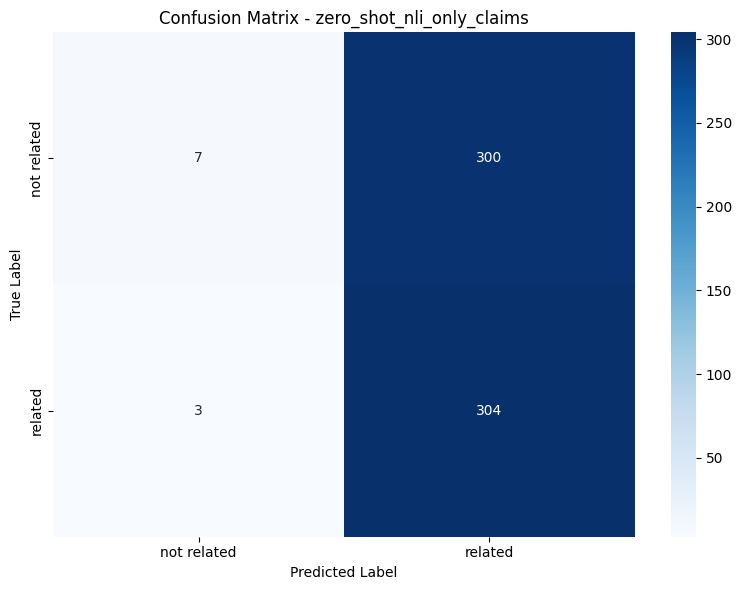

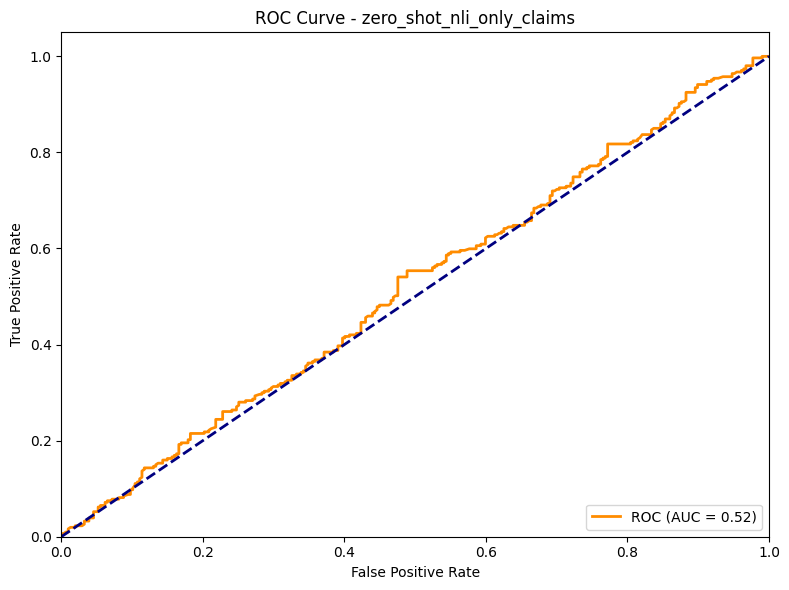

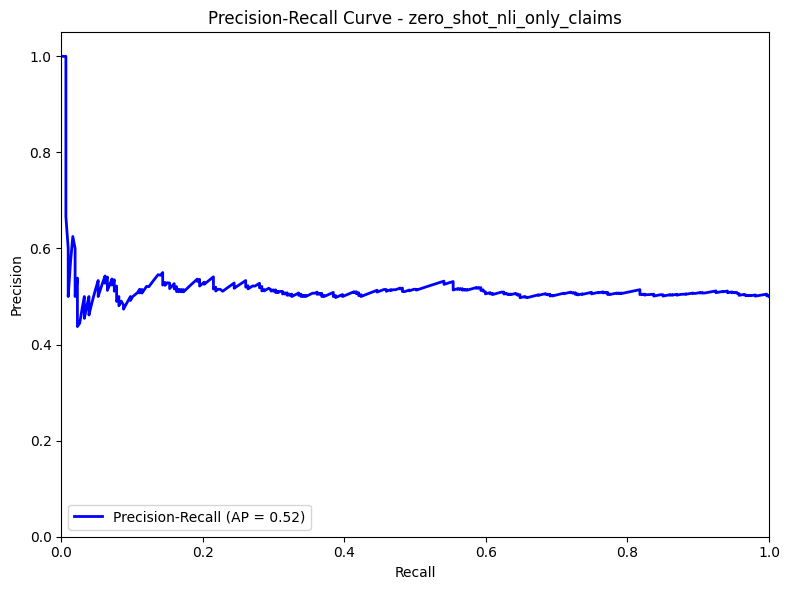

In [4]:
print("Running Zero-Shot Learning classification...")
zsl_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

zsl_preds_raw = zsl_classifier(  # Automatically classify the claims based on the evidence, using a hypothesis template
    test_claims,  # Pass the claims
    candidate_labels=candidate_labels,  # Candidate labels for classification in natural language
    multi_label=False  # False since a claim-evidence pair can only belong to one class
)
print("Zero-Shot Learning predictions completed.\n")

# Extract predictions and probabilities
y_pred_zsl = [pred['labels'][0] for pred in zsl_preds_raw]

# Extract probabilities for the positive class ('related')
zsl_probas = []
for pred in zsl_preds_raw:
    # Find the index of 'related' in the labels list
    related_idx = pred['labels'].index('related')
    # Get the corresponding score
    related_prob = pred['scores'][related_idx]
    zsl_probas.append(related_prob)

# Print the first 3 predictions and their probabilities
for i in range(3):
    pprint(f"Prediction {i+1}: {zsl_preds_raw[i]}")

# Evaluate the zero-shot learning results
zsl_results = evaluate_classification(
    y_true=y_test_true,
    y_pred=y_pred_zsl,
    base_filename="zero_shot_nli_only_claims",
    labels=candidate_labels,
    probas=zsl_probas,
    results_dir="results"
)

Running Zero-Shot Learning classification...


Device set to use cuda:0


Zero-Shot Learning predictions completed.

("Prediction 1: {'sequence': 'Claim: A cold day in Chicago in winter has "
 'nothing to do with the trend of global warming.\\nEvidence: "A novel '
 'probabilistic forecast system predicting anomalously warm 2018–2022 '
 'reinforcing the long-term global warming trend".\', \'labels\': [\'not '
 "related', 'related'], 'scores': [0.7414495944976807, 0.2585504353046417]}")
("Prediction 2: {'sequence': 'Claim: “…climate change will also reduce the "
 'number of cold days and cold spells.\\nEvidence: An alternative criticism is '
 'that the Church opposed particular scientific discoveries that it felt '
 'challenged its authority and power – particularly through the Reformation '
 "and on through the Enlightenment.', 'labels': ['related', 'not related'], "
 "'scores': [0.9925256371498108, 0.0074743423610925674]}")
("Prediction 3: {'sequence': 'Claim: Donald Trump thinks that climate change "
 'is a hoax, invented by the Chinese.\\nEvidence: With Gi

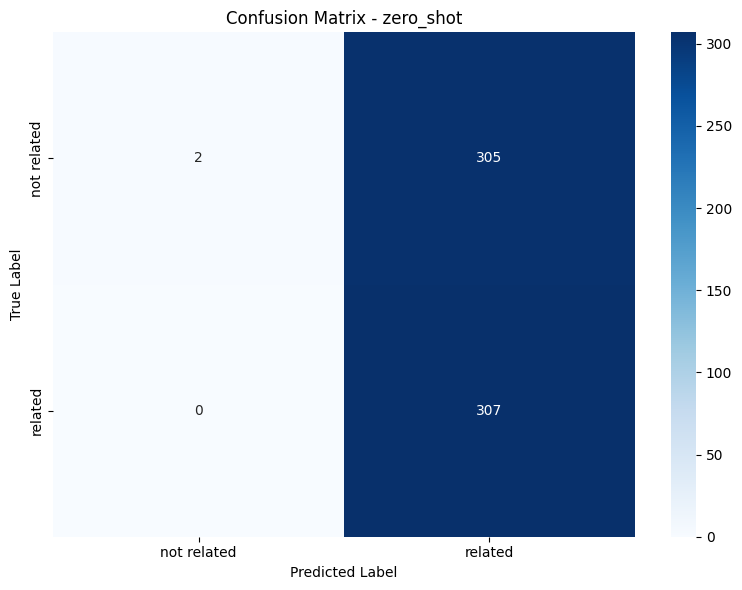

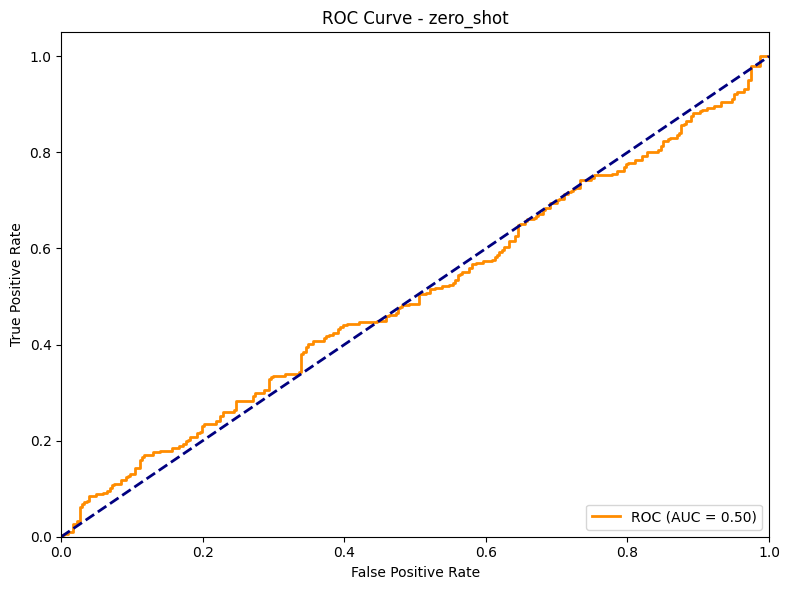

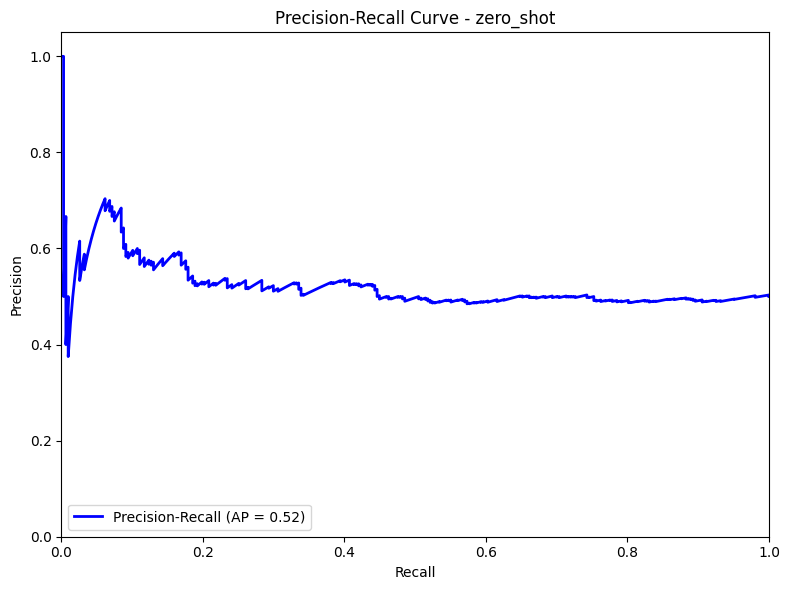

In [ ]:
print("Running Zero-Shot Learning classification...")
zsl_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

zsl_preds_raw = zsl_classifier(  # Automatically classify the claims based on the evidence, using a hypothesis template
    test_concat_text,  # Pass the claim-evidence pairs as a single text input
    candidate_labels=candidate_labels,  # Candidate labels for classification in natural language
    multi_label=False,  # False since a claim-evidence pair can only belong to one class
)
print("Zero-Shot Learning predictions completed.\n")

# Extract predictions and probabilities
y_pred_zsl = [pred['labels'][0] for pred in zsl_preds_raw]

# Extract probabilities for the positive class ('related')
zsl_probas = []
for pred in zsl_preds_raw:
    # Find the index of 'related' in the labels list
    related_idx = pred['labels'].index('related')
    # Get the corresponding score
    related_prob = pred['scores'][related_idx]
    zsl_probas.append(related_prob)

# Print the first 3 predictions and their probabilities
for i in range(3):
    pprint(f"Prediction {i+1}: {zsl_preds_raw[i]}")

# Evaluate the zero-shot learning results
zsl_results = evaluate_classification(
    y_true=y_test_true,
    y_pred=y_pred_zsl,
    base_filename="zero_shot_nli",
    labels=candidate_labels,
    probas=zsl_probas,
    results_dir="results"
)

## 3. Few-Shot Learning (FSL)

Warning: running the cells below can take long (especially the standard fine-tuning and classification).

### With a "generic" pre-trained Language Model and SetFit

We use contrastive learning (comparing a few pairs of positive and negative samples) in order to fine-tune a language model for the text classification task.

#### Utilities

In [34]:
# Function to run SetFit training and evaluation routine
def run_setfit_training(train_df: pd.DataFrame, val_df: pd.DataFrame, 
                        model_name='sentence-transformers/all-MiniLM-L6-v2',
                        num_epochs=5, batch_size=16, learning_rate=2e-5, sample_size=16,
                        metric='f1', num_iterations=10, seed=42):
    """
    Run SetFit training and evaluation routine.
    
    Args:
        train_df (pl.DataFrame): Training DataFrame with 'text' and 'label' columns.
        val_df (pl.DataFrame): Validation DataFrame with 'text' and 'label' columns.
        model_name (str): Pretrained model name for SetFit.
        num_epochs (int): Number of epochs for training.
        batch_size (int): Batch size for training.
        learning_rate (float): Learning rate for the optimizer.
        sample_size (int): Number of samples to use for training in each iteration.
        metric (str): Metric to optimize during training ('f1', 'accuracy', etc.).
        num_iterations (int): Number of iterations to run the training process.
        seed (int): Random seed for reproducibility.
    
    Returns:
        list: A list of dictionaries containing evaluation metrics for each iteration.
    """
    
    # Prepare the validation set
    val_set = Dataset.from_pandas(val_df[['text', 'label']])

    # Store results across iterations (for different metrics and iterations)
    iteration_results = []
    best_score = 0
    best_model = None
    best_iteration = 0

    # Run the sampling and training process with SetFit
    for iteration in range(num_iterations):
        print(f"\nIteration {iteration + 1}/{num_iterations}")

        # Create a fresh model for each iteration to avoid contamination
        model = setfit.SetFitModel.from_pretrained(model_name)

        # Create a sample from the training data and convert to a Dataset
        train_df = train_df.sample(n=sample_size, random_state=seed + iteration)  # Sample a balanced dataset
        train_samples = Dataset.from_pandas(train_df[['text', 'label']])

        # Create the training arguments
        train_args = setfit.TrainingArguments(
            num_epochs=(num_epochs, num_epochs),  # Tuple format: (sentence_transformer_epochs, head_epochs)
            batch_size=(batch_size, batch_size),  # Tuple format: (sentence_transformer_batch, head_batch)
            body_learning_rate=(learning_rate, learning_rate),  # Tuple format for body learning rate (first for sentence transformer, second for head classifier)
        )

        # Initialize and train SetFit model
        trainer = setfit.Trainer(
            model=model,
            train_dataset=train_samples,  # Pairs of text and labels for Contrastive Learning
            eval_dataset=val_set,  # Validation set for evaluation
            metric=metric,  # Metric to optimize
            args=train_args  # Training arguments
        )

        trainer.train()  # Train the model
        print("Training completed.")

        # Evaluate on validation set (for hyperparameter tuning/model selection)
        val_predictions = trainer.model.predict(val_set['text'])
        val_metrics = {
            'accuracy': accuracy_score(val_set['label'], val_predictions),
            'f1': f1_score(val_set['label'], val_predictions),
            'precision': precision_score(val_set['label'], val_predictions),
            'recall': recall_score(val_set['label'], val_predictions)
        }
        
        # Store results for this iteration
        iteration_results.append(val_metrics)
        print(f"Validation F1: {val_metrics['f1']:.4f}")

        # Check if this is the best model so far
        current_score = val_metrics[metric]
        if current_score > best_score:
            best_score = current_score
            best_iteration = iteration + 1
            # Clean up previous best model
            if best_model is not None:
                del best_model
            # Store reference to current best model
            best_model = trainer.model
            print(f"New best model found with {metric}: {best_score:.4f}")

        # Clean up memory for this iteration
        if best_model is trainer.model:
            # This is the best model, only delete trainer
            del model, trainer
        else:
            # This is not the best model, delete everything
            del model, trainer

        # Clear CUDA cache if using GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()  # Wait for all operations to complete
    
    print('Finished training in all iterations. Saving the results to a parquet file...')
    
    # Save the best model
    san_model_name = model_name.split(sep='/')[-1]  # Sanitize model name for file path, keep only the last part
    model_path = os.path.join('models', f'setfit_best_{san_model_name}_{sample_size}')
    os.makedirs(model_path, exist_ok=True)
    best_model.save_pretrained(model_path)  # Save the best model to the specified path
    print(f'Best model saved to: {model_path}')

    # Save the results in a polars DataFrame
    results_df = pd.DataFrame(iteration_results)
    results_df['iteration'] = range(1, len(results_df) + 1)  # Add iteration number to the results DataFrame

    # Save the results DataFrame to a Parquet file
    results_path = os.path.join('results', f'setfit_results_{san_model_name}_{sample_size}.parquet')
    os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure the directory exists
    results_df.to_parquet(results_path)
    print(f'Results saved to: {results_path}')

    return results_df

#### With 16 examples (few-shot learning with 16 labelled instances)

In [ ]:
# Rename columns to match SetFit requirements (labels should be 'label'), creating a copy
train_df_setfit = train_df.copy()
val_df_setfit = val_df.copy()
if 'labels' in train_df_setfit.columns:
    train_df_setfit.rename(columns={'labels': 'label'}, inplace=True)
if 'labels' in val_df_setfit.columns:
    val_df_setfit.rename(columns={'labels': 'label'}, inplace=True)

# In each of the resulting data frames, create a column 'text' that contains the concatenated claim and evidence
train_df_setfit['text'] = train_df_setfit.apply(lambda row: f"Claim: {row['claim']}\nEvidence: {row['evidence']}", axis=1)
val_df_setfit['text'] = val_df_setfit.apply(lambda row: f"Claim: {row['claim']}\nEvidence: {row['evidence']}", axis=1)

# Define sample size (labelled examples for training)
sample_size = 16
num_iterations = 10  # Run several iterations for the sample size (labelled instances) to minimize the impact of randomness
metric = 'accuracy'  # Metric to optimize
model_name = "sentence-transformers/all-MiniLM-L6-v2"  # Path to the pre-trained model
batch_size = 64 # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 20  # Number of epochs for training
learning_rate= 2e-5  # Learning rate for the optimizer

results_setfit = run_setfit_training(
    train_df=train_df_setfit, 
    val_df=val_df_setfit, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=42
)


Iteration 1/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 146
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.273000
50,0.157600


Training completed.
Validation F1: 0.6288
New best model found with accuracy: 0.5293

Iteration 2/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 146
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.267900
50,0.153600


Training completed.
Validation F1: 0.6354

Iteration 3/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 146
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.224300
50,0.154700


Training completed.
Validation F1: 0.6295
New best model found with accuracy: 0.5350

Iteration 4/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 146
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.287700
50,0.154300


Training completed.
Validation F1: 0.6181

Iteration 5/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 146
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.258200
50,0.153100


Training completed.
Validation F1: 0.6261

Iteration 6/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 146
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.277500
50,0.153700


Training completed.
Validation F1: 0.6234

Iteration 7/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 146
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.247400
50,0.157500


Training completed.
Validation F1: 0.6299

Iteration 8/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 146
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.263200
50,0.158600


Training completed.
Validation F1: 0.6313

Iteration 9/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 146
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.255900
50,0.160000


Training completed.
Validation F1: 0.6220

Iteration 10/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 146
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.266500
50,0.155600


Training completed.
Validation F1: 0.6390
New best model found with accuracy: 0.5354
Finished training in all iterations. Saving the results to a parquet file...
Best model saved to: models/setfit_best_all-MiniLM-L6-v2
Results saved to: results/setfit_results_all-MiniLM-L6-v2.parquet


In [26]:
model_name = 'all-MiniLM-L6-v2'
sample_size = 16  # Sample size used in the training

results_setfit = pd.read_parquet(os.path.join('results', f'setfit_results_{model_name}_{sample_size}.parquet'))

print(f'Results for model: {model_name}, with sample size (few-shot examples): {sample_size}')
display(results_setfit)

# Print maximum of all metrics across iterations
metrics = ['accuracy', 'f1', 'precision', 'recall']
for metric in metrics:
    max_value = results_setfit[metric].max()
    best_iteration = results_setfit.loc[results_setfit[metric] == max_value, 'iteration'].values[0]
    print(f"Best {metric} across iterations: {max_value:.4f} (Iteration {best_iteration})")

Results for model: all-MiniLM-L6-v2, with sample size (few-shot examples): 16


,accuracy,f1,precision,recall,iteration
0,0.529316,0.628773,0.519088,0.797231,1
1,0.527687,0.635449,0.517400,0.823290,2
2,0.535016,0.629461,0.523193,0.789902,3
3,0.530537,0.618085,0.520938,0.759772,4
4,0.529723,0.626093,0.519613,0.787459,5
5,0.522394,0.623435,0.514573,0.790717,6
6,0.527687,0.629866,0.517838,0.803746,7
7,0.527687,0.631278,0.517727,0.808632,8
8,0.524430,0.622006,0.516112,0.782573,9
9,0.535423,0.639038,0.522504,0.822476,10


Best accuracy across iterations: 0.5354 (Iteration 10)
Best f1 across iterations: 0.6390 (Iteration 10)
Best precision across iterations: 0.5232 (Iteration 3)
Best recall across iterations: 0.8233 (Iteration 2)


Once we have found the best model (in this case, the one with the highest accuracy), we load it and evaluate it on the test set.

Model loaded from: models/setfit_best_all-MiniLM-L6-v2_16
Accuracy: 0.5407

              precision    recall  f1-score   support

 not related       0.58      0.28      0.38       307
     related       0.53      0.80      0.63       307

    accuracy                           0.54       614
   macro avg       0.56      0.54      0.51       614
weighted avg       0.56      0.54      0.51       614



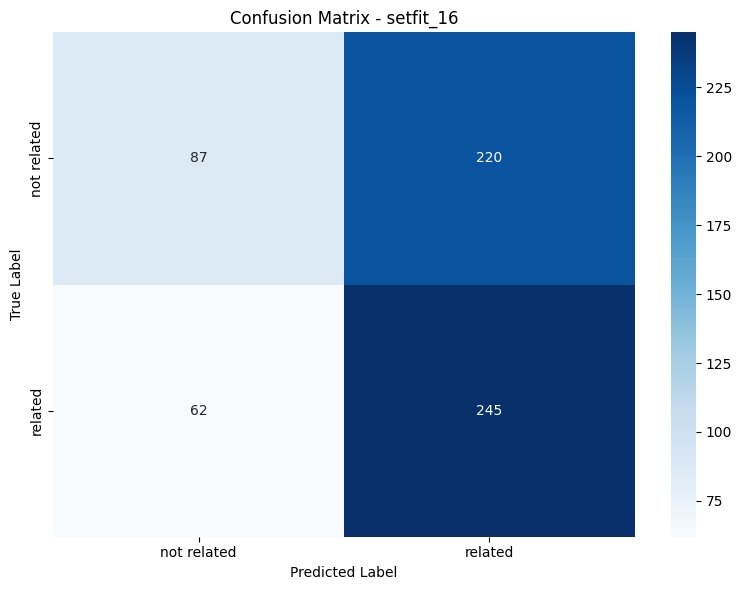

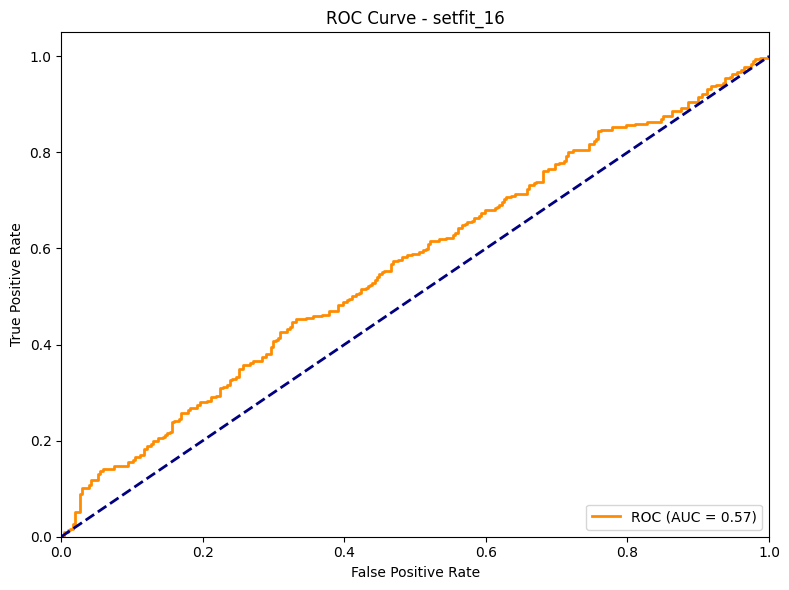

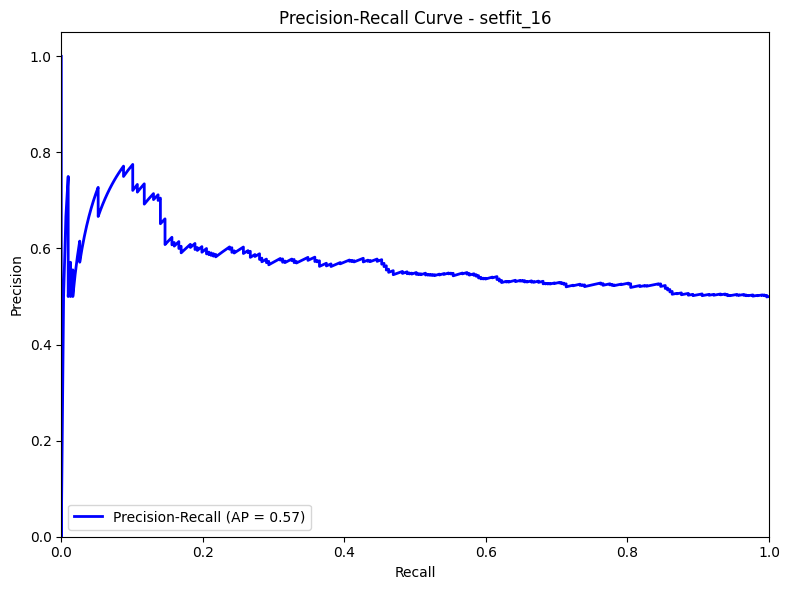

In [38]:
# Load the best SetFit model from the saved path
model_name = 'all-MiniLM-L6-v2'
sample_size = 16  # Sample size used in the training
model_path = os.path.join('models', f'setfit_best_{model_name}_{sample_size}')

# Load the saved model
best_setfit_model = SetFitModel.from_pretrained(model_path)
print(f"Model loaded from: {model_path}")

# Prepare test data in the same format as training
test_df_setfit = test_df.copy()
test_df_setfit['text'] = test_df_setfit.apply(lambda row: f"Claim: {row['claim']}\nEvidence: {row['evidence']}", axis=1)
test_df_setfit['label'] = test_df_setfit['labels']  # Ensure 'label' column exists for SetFit

# Make predictions on the test set
test_predictions = best_setfit_model.predict(test_df_setfit['text'].tolist())
test_predictions_list = test_predictions.tolist()  # Convert predictions to a list

# Convert predictions to label names
y_pred_setfit_test = [labels_map[pred] for pred in test_predictions_list]

# Get prediction probabilities if needed
test_probabilities = best_setfit_model.predict_proba(test_df_setfit['text'].tolist())
test_probabilities_list = test_probabilities.tolist()  # Convert probabilities to a list

# Extract probabilities for the positive class ('related' = label 1)
setfit_probas = test_probabilities[:, 1]  # Assuming label 1 is 'related'

# Evaluate the SetFit model on test set
setfit_test_results = evaluate_classification(
    y_true=y_test_true,
    y_pred=y_pred_setfit_test,
    base_filename=f"setfit_{sample_size}",
    labels=candidate_labels,
    probas=setfit_probas,
    results_dir="results"
)

#### With 32 examples (few-shot learning with 32 labelled instances)

How much does performance improve across the board with double the number of examples?

In [35]:
# Rename columns to match SetFit requirements (labels should be 'label'), creating a copy
train_df_setfit = train_df.copy()
val_df_setfit = val_df.copy()
if 'labels' in train_df_setfit.columns:
    train_df_setfit.rename(columns={'labels': 'label'}, inplace=True)
if 'labels' in val_df_setfit.columns:
    val_df_setfit.rename(columns={'labels': 'label'}, inplace=True)

# In each of the resulting data frames, create a column 'text' that contains the concatenated claim and evidence
train_df_setfit['text'] = train_df_setfit.apply(lambda row: f"Claim: {row['claim']}\nEvidence: {row['evidence']}", axis=1)
val_df_setfit['text'] = val_df_setfit.apply(lambda row: f"Claim: {row['claim']}\nEvidence: {row['evidence']}", axis=1)

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 10  # Run several iterations for the sample size (labelled instances) to minimize the impact of randomness
metric = 'accuracy'  # Metric to optimize
model_name = "sentence-transformers/all-MiniLM-L6-v2"  # Path to the pre-trained model
batch_size = 64 # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 20  # Number of epochs for training
learning_rate= 2e-5  # Learning rate for the optimizer

results_setfit = run_setfit_training(
    train_df=train_df_setfit, 
    val_df=val_df_setfit, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=42
)


Iteration 1/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 562
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.281900
50,0.225300
100,0.032200
150,0.003300


Training completed.
Validation F1: 0.6600
New best model found with accuracy: 0.5831

Iteration 2/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 562
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.284200
50,0.227100
100,0.032200
150,0.003400


Training completed.
Validation F1: 0.6607

Iteration 3/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 562
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.249100
50,0.224500
100,0.030500
150,0.003400


Training completed.
Validation F1: 0.6621

Iteration 4/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 562
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.301400
50,0.222800
100,0.028600
150,0.003400


Training completed.
Validation F1: 0.6607

Iteration 5/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 562
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.293800
50,0.223600
100,0.027100
150,0.003300


Training completed.
Validation F1: 0.6596

Iteration 6/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 562
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.286100
50,0.222600
100,0.027300
150,0.003000


Training completed.
Validation F1: 0.6620
New best model found with accuracy: 0.5835

Iteration 7/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 562
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.248200
50,0.224400
100,0.026600
150,0.003300


Training completed.
Validation F1: 0.6543

Iteration 8/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 562
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.272900
50,0.226900
100,0.034000
150,0.003300


Training completed.
Validation F1: 0.6601

Iteration 9/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 562
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.302100
50,0.227000
100,0.029700
150,0.003200


Training completed.
Validation F1: 0.6559

Iteration 10/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 562
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.296100
50,0.224100
100,0.030000
150,0.003300


Training completed.
Validation F1: 0.6616
Finished training in all iterations. Saving the results to a parquet file...
Best model saved to: models/setfit_best_all-MiniLM-L6-v2_32
Results saved to: results/setfit_results_all-MiniLM-L6-v2_32.parquet


In [36]:
model_name = 'all-MiniLM-L6-v2'
sample_size = 32  # Sample size used in the training

results_setfit = pd.read_parquet(os.path.join('results', f'setfit_results_{model_name}_{sample_size}.parquet'))

print(f'Results for model: {model_name}, with sample size (few-shot examples): {sample_size}')
display(results_setfit)

# Print maximum of all metrics across iterations
metrics = ['accuracy', 'f1', 'precision', 'recall']
for metric in metrics:
    max_value = results_setfit[metric].max()
    best_iteration = results_setfit.loc[results_setfit[metric] == max_value, 'iteration'].values[0]
    print(f"Best {metric} across iterations: {max_value:.4f} (Iteration {best_iteration})")

Results for model: all-MiniLM-L6-v2, with sample size (few-shot examples): 32


,accuracy,f1,precision,recall,iteration
0,0.583062,0.660027,0.557175,0.809446,1
1,0.582248,0.660714,0.556236,0.813518,2
2,0.581026,0.662069,0.554761,0.820847,3
3,0.581026,0.660732,0.555125,0.815961,4
4,0.580212,0.659624,0.554692,0.813518,5
5,0.583469,0.662042,0.556976,0.815961,6
6,0.573697,0.654341,0.550250,0.807003,7
7,0.581026,0.660059,0.555309,0.813518,8
8,0.573290,0.655942,0.549505,0.813518,9
9,0.583062,0.661599,0.556730,0.815147,10


Best accuracy across iterations: 0.5835 (Iteration 6)
Best f1 across iterations: 0.6621 (Iteration 3)
Best precision across iterations: 0.5572 (Iteration 1)
Best recall across iterations: 0.8208 (Iteration 3)


Model loaded from: models/setfit_best_all-MiniLM-L6-v2_32
Accuracy: 0.5635

              precision    recall  f1-score   support

 not related       0.62      0.34      0.44       307
     related       0.54      0.79      0.64       307

    accuracy                           0.56       614
   macro avg       0.58      0.56      0.54       614
weighted avg       0.58      0.56      0.54       614



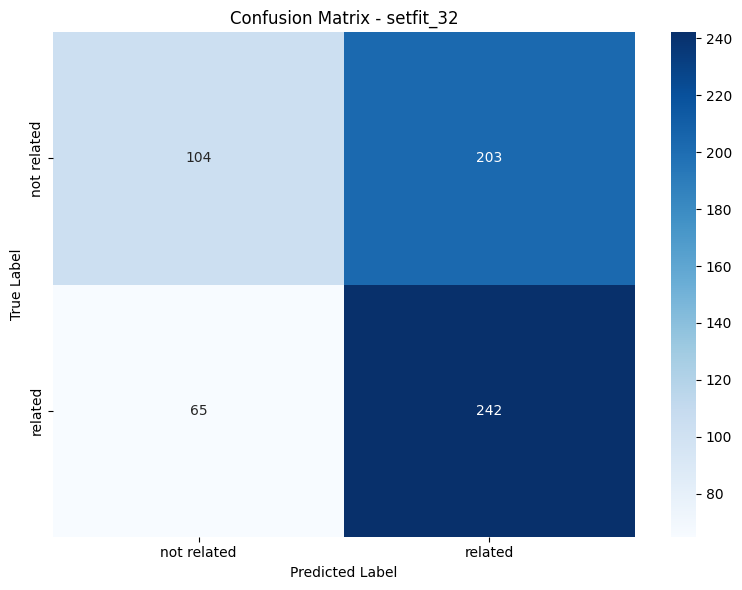

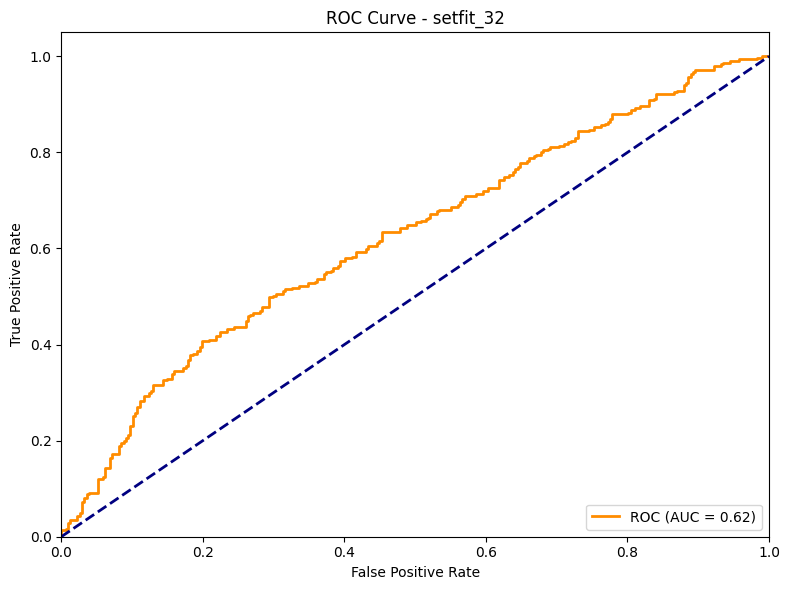

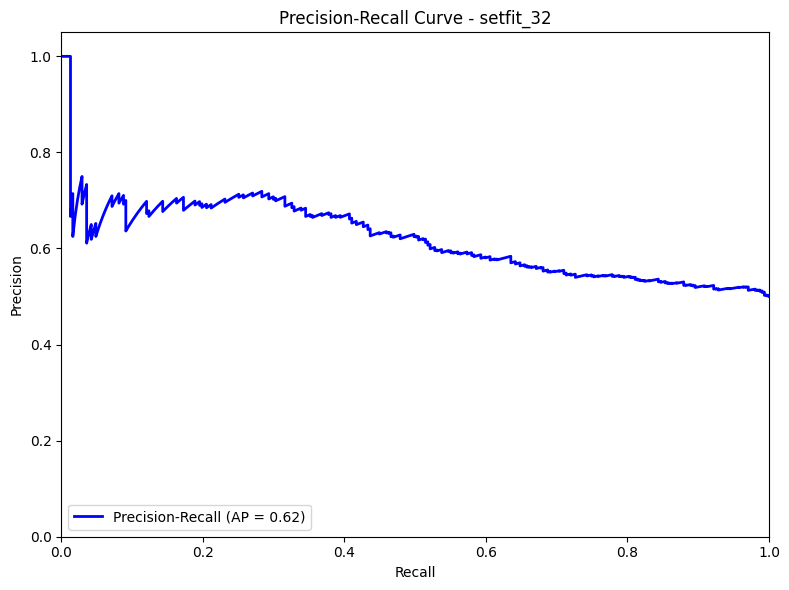

In [39]:
# Load the best SetFit model from the saved path
model_name = 'all-MiniLM-L6-v2'
sample_size = 32  # Sample size used in the training
model_path = os.path.join('models', f'setfit_best_{model_name}_{sample_size}')

# Load the saved model
best_setfit_model = SetFitModel.from_pretrained(model_path)
print(f"Model loaded from: {model_path}")

# Prepare test data in the same format as training
test_df_setfit = test_df.copy()
test_df_setfit['text'] = test_df_setfit.apply(lambda row: f"Claim: {row['claim']}\nEvidence: {row['evidence']}", axis=1)
test_df_setfit['label'] = test_df_setfit['labels']  # Ensure 'label' column exists for SetFit

# Make predictions on the test set
test_predictions = best_setfit_model.predict(test_df_setfit['text'].tolist())
test_predictions_list = test_predictions.tolist()  # Convert predictions to a list

# Convert predictions to label names
y_pred_setfit_test = [labels_map[pred] for pred in test_predictions_list]

# Get prediction probabilities if needed
test_probabilities = best_setfit_model.predict_proba(test_df_setfit['text'].tolist())
test_probabilities_list = test_probabilities.tolist()  # Convert probabilities to a list

# Extract probabilities for the positive class ('related' = label 1)
setfit_probas = test_probabilities[:, 1]  # Assuming label 1 is 'related'

# Evaluate the SetFit model on test set
setfit_test_results = evaluate_classification(
    y_true=y_test_true,
    y_pred=y_pred_setfit_test,
    base_filename=f"setfit_{sample_size}",
    labels=candidate_labels,
    probas=setfit_probas,
    results_dir="results"
)

### Standard fine-tuning with a model pre-trained for fact-checking

The question here is: can regular fine-tuning with few shot learning overcome the performance of a generic pre-trained LM fine-tuned with SetFit?

For this task, we will be using the [albert-xlarge-vitaminc-mnli](https://huggingface.co/tals/albert-xlarge-vitaminc-mnli) model (explained in this [paper](https://aclanthology.org/2021.naacl-main.52/)), pre-trained on claims and actual evidence from Wikipedia revisions.

In [ ]:
model_name = "tals/albert-xlarge-vitaminc-mnli"  # Path to the pre-trained model
num_labels = 2  # Number of labels for the classification task (in this case, binary classification)
max_length = int(AutoModel.from_pretrained(model_name).config.max_position_embeddings)  # Maximum length of the input sequences (truncation if larger than this). Set dynamically based on the chosen model.
sample_size = 16  # Number of labelled instances for training

print(f"Model: {model_name}, Max Length: {max_length}")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=max_length)

# Create a sample from the training data and convert to a Dataset
train_df_ft = train_df.copy()
val_df_ft = val_df.copy()

# In each of the resulting data frames, create a column 'text' that contains the concatenated claim and evidence
train_df_ft['text'] = train_df_ft.apply(lambda row: f"Claim: {row['claim']}\nEvidence: {row['evidence']}", axis=1)
val_df_ft['text'] = train_df_ft.apply(lambda row: f"Claim: {row['claim']}\nEvidence: {row['evidence']}", axis=1)

train_df_ft = train_df_ft.sample(n=sample_size, random_state=42)  # Sample a random dataset

# Create the Arrow Dataset from the Pandas Data Frame
train_set = Dataset.from_pandas(train_df[['text', 'labels']])
val_set = Dataset.from_pandas(val_df_ft[['text', 'labels']])

# Now, we actually tokenize the datasets
train_set = train_set.map(tokenize, batched=True, remove_columns=["text"])
val_set = val_set.map(tokenize, batched=True, remove_columns=["text"])

# Convert the data in the datasets to PyTorch tensors
train_set.set_format(type='torch')
val_set.set_format(type='torch')

# Display the first example from the training set
print("\nFirst example from the training set:")
print(train_set[0])

# Load the model for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    num_labels=num_labels,
    problem_type="single_label_classification"
)

# Set training arguments
san_model_name = model_name.split(sep='/')[-1]  # Sanitize model name for file path, keep only the last part

train_args = TrainingArguments(
    output_dir = os.path.join('models', f'cls_fine_tuning_{san_model_name}'),
    eval_strategy = "epoch",  # Evaluate at the end of each epoch
    save_strategy = "epoch",  # Save the model at the end of each epoch
    logging_strategy = "steps",  # Log training progress every logging_steps
    logging_steps = 50,
    learning_rate = 2e-5,  # Learning rate for fine-tuning the language model
    per_device_train_batch_size = 32,  # Batch size for training
    per_device_eval_batch_size  = 32,  # Batch size for evaluation
    num_train_epochs = 20,  # Maximum number of epochs for training (unless early stopping is triggered)
    weight_decay = 0.01,  # Weight decay for regularization
    load_best_model_at_end = True,  # Load the best model at the end of training based on evaluation loss
    metric_for_best_model = "eval_loss",  # Metric to use for determining the best model
    save_total_limit = 2,  # Limit the total number of saved models to the best 2 models
    seed = 42,  # Set random seed for reproducibility
    report_to = "none",  # Disable wandb
    fp16 = True, # Enables mixed precision training (compatible on some GPUs, but not all). Set to True if you have a compatible GPU.
    gradient_accumulation_steps = 2  # Gradient accumulation steps to effectively increase the batch size without increasing memory usage
)

print("Output directory for the model:", train_args.output_dir)

In [ ]:
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_set,
    eval_dataset=val_set.shuffle(seed=42),  # Shuffle the validation set for evaluation
    compute_metrics=lambda p: {  # Return a dictionary of metrics
        "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1)),  # Compare the true labels with the predicted labels, by selecting the index with the highest probability
        "f1": f1_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        "precision": precision_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        "recall": recall_score(p.label_ids, np.argmax(p.predictions, axis=1))
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]  # Early stopping after 3 epochs without improvement
)

train_output = trainer.train()

# Filter for epoch logs (those that have 'epoch' key)
log_history = trainer.state.log_history
epoch_logs = [log for log in log_history if 'epoch' in log]

# Convert to Polars DataFrame
results_df = pd.DataFrame(epoch_logs)

# Save results in a Parquet file
results_path = os.path.join('results', 'part_2', 'a', f'cls_fine_tuning_results_{san_model_name}.parquet')
os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure the directory exists
results_df.write_parquet(results_path)
print(f'Results saved to: {results_path}')